In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import entropy
import warnings
import logging

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.inference.nn import CEVAE
from causalml.propensity import ElasticNetPropensityModel
from causalml.metrics import *
from causalml.dataset import simulate_hidden_confounder

%matplotlib inline

warnings.filterwarnings('ignore')
logger = logging.getLogger('causalml')
logger.setLevel(logging.DEBUG)

plt.style.use('fivethirtyeight')
sns.set_palette('Paired')
plt.rcParams['figure.figsize'] = (12,8)

/Users/jing.pan/anaconda3/envs/causalml_3_6/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


# IHDP semi-synthetic dataset

Hill introduced a semi-synthetic dataset constructed from the Infant Health
and Development Program (IHDP). This dataset is based on a randomized experiment
investigating the effect of home visits by specialists on future cognitive scores. The IHDP simulation is considered the de-facto standard benchmark for neural network treatment effect
estimation methods.

In [6]:
# load all ihadp data
df = pd.DataFrame()
for i in range(1, 10):
    data = pd.read_csv('/Users/jing.pan/Projects/causalml/examples/data/ihdp_npci_' + str(i) + '.csv', header=None)
    df = pd.concat([data, df])
cols =  ["treatment", "y_factual", "y_cfactual", "mu0", "mu1"] + [i for i in range(25)]
df.columns = cols
print(df.shape)

# replicate the data 100 times
replications = 100
df = pd.concat([df]*replications, ignore_index=True)
print(df.shape)

(6723, 30)
(672300, 30)


In [7]:
# set which features are binary
binfeats = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
# set which features are continuous
contfeats = [i for i in range(25) if i not in binfeats]

# reorder features with binary first and continuous after
perm = binfeats + contfeats

In [8]:
df = df.reset_index(drop=True)
df.head()

,treatment,y_factual,y_cfactual,mu0,mu1,0,1,2,3,4,...,15,16,17,18,19,20,21,22,23,24
0,1,49.647921,34.950762,37.173291,50.383798,-0.528603,-0.343455,1.128554,0.161703,-0.316603,...,1,1,1,1,0,0,0,0,0,0
1,0,16.073412,49.435313,16.087249,49.546234,-1.736945,-1.802002,0.383828,2.244320,-0.629189,...,1,1,1,1,0,0,0,0,0,0
2,0,19.643007,48.598210,18.044855,49.661068,-0.807451,-0.202946,-0.360898,-0.879606,0.808706,...,1,0,1,1,0,0,0,0,0,0
3,0,26.368322,49.715204,24.605964,49.971196,0.390083,0.596582,-1.850350,-0.879606,-0.004017,...,1,0,1,1,0,0,0,0,0,0
4,0,20.258893,51.147418,20.612816,49.794120,-1.045229,-0.602710,0.011465,0.161703,0.683672,...,1,1,1,1,0,0,0,0,0,0


In [9]:
X = df[perm].values
treatment = df['treatment'].values
y = df['y_factual'].values
y_cf = df['y_cfactual'].values
tau = df.apply(lambda d: d['y_factual'] - d['y_cfactual'] if d['treatment']==1 
               else d['y_cfactual'] - d['y_factual'], 
               axis=1)
mu_0 = df['mu0'].values
mu_1 = df['mu1'].values

In [10]:
# seperate for train and test
itr, ite = train_test_split(np.arange(X.shape[0]), test_size=0.2, random_state=1)
X_train, treatment_train, y_train, y_cf_train, tau_train, mu_0_train, mu_1_train = X[itr], treatment[itr], y[itr], y_cf[itr], tau[itr], mu_0[itr], mu_1[itr]
X_val, treatment_val, y_val, y_cf_val, tau_val, mu_0_val, mu_1_val = X[ite], treatment[ite], y[ite], y_cf[ite], tau[ite], mu_0[ite], mu_1[ite]

## CEVAE Model

In [11]:
# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 0.001
learning_rate_decay = 0.01
num_layers = 2

In [12]:
cevae = CEVAE_MODEL(outcome_dist=outcome_dist,
                    latent_dim=latent_dim,
                    hidden_dim=hidden_dim,
                    num_epochs=num_epochs,
                    batch_size=batch_size,
                    learning_rate=learning_rate,
                    learning_rate_decay=learning_rate_decay,
                    num_layers=num_layers)

In [13]:
# fit
losses = cevae.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(treatment_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

INFO 	 Training with 538 minibatches per epoch
DEBUG 	 step     0 loss = 787.849
DEBUG 	 step     1 loss = 403.756
DEBUG 	 step     2 loss = 327.529
DEBUG 	 step     3 loss = 294.265
DEBUG 	 step     4 loss = 288.57
DEBUG 	 step     5 loss = 267.276
DEBUG 	 step     6 loss = 246.92
DEBUG 	 step     7 loss = 254.009
DEBUG 	 step     8 loss = 223.337
DEBUG 	 step     9 loss = 207.599
DEBUG 	 step    10 loss = 201.528
DEBUG 	 step    11 loss = 195.781
DEBUG 	 step    12 loss = 194.654
DEBUG 	 step    13 loss = 200.068
DEBUG 	 step    14 loss = 166.413
DEBUG 	 step    15 loss = 175.201
DEBUG 	 step    16 loss = 157.356
DEBUG 	 step    17 loss = 169.168
DEBUG 	 step    18 loss = 173.668
DEBUG 	 step    19 loss = 150.117
DEBUG 	 step    20 loss = 133.326
DEBUG 	 step    21 loss = 136.675
DEBUG 	 step    22 loss = 142.996
DEBUG 	 step    23 loss = 130.821
DEBUG 	 step    24 loss = 138.304
DEBUG 	 step    25 loss = 128.975
DEBUG 	 step    26 loss = 118.373
DEBUG 	 step    27 loss = 120.717
DEB

In [14]:
# predict
ite_train = cevae.predict(X_train)
ite_val = cevae.predict(X_val)

INFO 	 Evaluating 538 minibatches
DEBUG 	 batch ate = 1.99614
DEBUG 	 batch ate = 2.05908
DEBUG 	 batch ate = 1.8127
DEBUG 	 batch ate = 1.78229
DEBUG 	 batch ate = 1.79414
DEBUG 	 batch ate = 1.72899
DEBUG 	 batch ate = 1.89112
DEBUG 	 batch ate = 1.95692
DEBUG 	 batch ate = 1.97951
DEBUG 	 batch ate = 1.93082
DEBUG 	 batch ate = 1.99103
DEBUG 	 batch ate = 1.87428
DEBUG 	 batch ate = 1.74325
DEBUG 	 batch ate = 1.94172
DEBUG 	 batch ate = 1.78928
DEBUG 	 batch ate = 1.87605
DEBUG 	 batch ate = 2.09413
DEBUG 	 batch ate = 1.82006
DEBUG 	 batch ate = 2.0108
DEBUG 	 batch ate = 1.88488
DEBUG 	 batch ate = 2.06903
DEBUG 	 batch ate = 1.87673
DEBUG 	 batch ate = 1.84459
DEBUG 	 batch ate = 1.74286
DEBUG 	 batch ate = 1.95147
DEBUG 	 batch ate = 1.85704
DEBUG 	 batch ate = 1.75095
DEBUG 	 batch ate = 2.1258
DEBUG 	 batch ate = 1.9351
DEBUG 	 batch ate = 1.92102
DEBUG 	 batch ate = 2.07946
DEBUG 	 batch ate = 1.9565
DEBUG 	 batch ate = 2.20442
DEBUG 	 batch ate = 1.86246
DEBUG 	 batch ate =

In [15]:
ate_train = ite_train.mean()
ate_val = ite_val.mean()
print(ate_train, ate_val)

1.9121237 1.9194816


## Meta Learners

In [16]:
# fit propensity model
p_model = ElasticNetPropensityModel()
p_train = p_model.fit_predict(X_train, treatment_train)
p_val = p_model.fit_predict(X_val, treatment_val)

In [17]:
s_learner = BaseSRegressor(LGBMRegressor())
s_ate = s_learner.estimate_ate(X_train, treatment_train, y_train)[0]
s_ite_train = s_learner.fit_predict(X_train, treatment_train, y_train)
s_ite_val = s_learner.predict(X_val)

t_learner = BaseTRegressor(LGBMRegressor())
t_ate = t_learner.estimate_ate(X_train, treatment_train, y_train)[0][0]
t_ite_train = t_learner.fit_predict(X_train, treatment_train, y_train)
t_ite_val = t_learner.predict(X_val, treatment_val, y_val)

x_learner = BaseXRegressor(LGBMRegressor())
x_ate = x_learner.estimate_ate(X_train, treatment_train, y_train, p_train)[0][0]
x_ite_train = x_learner.fit_predict(X_train, treatment_train, y_train, p_train)
x_ite_val = x_learner.predict(X_val, treatment_val, y_val, p_val)

r_learner = BaseRRegressor(LGBMRegressor())
r_ate = r_learner.estimate_ate(X_train, treatment_train, y_train, p_train)[0][0]
r_ite_train = r_learner.fit_predict(X_train, treatment_train, y_train, p_train)
r_ite_val = r_learner.predict(X_val)

## Model Results Comparsion

### Training

In [18]:
df_preds_train = pd.DataFrame([s_ite_train.ravel(),
                               t_ite_train.ravel(),
                               x_ite_train.ravel(),
                               r_ite_train.ravel(),
                               ite_train.ravel(),
                               tau_train.ravel(),
                               treatment_train.ravel(),
                               y_train.ravel()],
                               index=['S','T','X','R','CEVAE','tau','w','y']).T

df_cumgain_train = get_cumgain(df_preds_train)

In [19]:
df_result_train = pd.DataFrame([s_ate, t_ate, x_ate, r_ate, ate_train, tau_train.mean()],
                               index=['S','T','X','R','CEVAE','actual'], columns=['ATE'])
df_result_train['MAE'] = [mean_absolute_error(t,p) for t,p in zip([s_ite_train, t_ite_train, x_ite_train, r_ite_train, ite_train],
                                                                  [tau_train.values.reshape(-1,1)]*5 )
                          ] + [None]
df_result_train['AUUC'] = auuc_score(df_preds_train)

In [20]:
df_result_train

,ATE,MAE,AUUC
S,4.690540,4.581416,0.684130
T,4.708557,4.715296,0.684878
X,4.555315,4.549527,0.671958
R,0.771637,6.024471,0.584770
CEVAE,1.912124,5.313886,0.573757
actual,4.755900,NaN,NaN


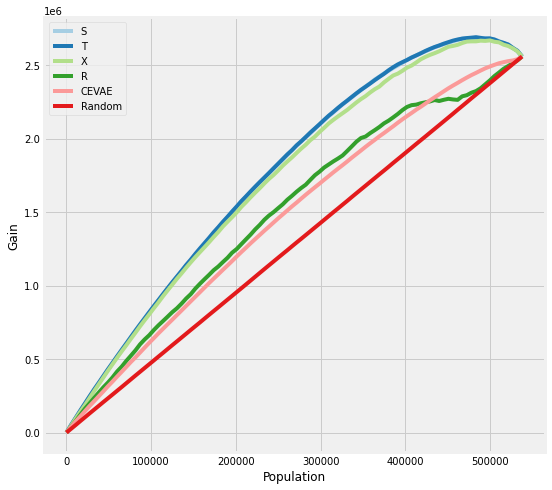

In [21]:
plot_gain(df_preds_train)

### Validation

In [22]:
df_preds_val = pd.DataFrame([s_ite_val.ravel(),
                             t_ite_val.ravel(),
                             x_ite_val.ravel(),
                             r_ite_val.ravel(),
                             ite_val.ravel(),
                             tau_val.ravel(),
                             treatment_val.ravel(),
                             y_val.ravel()],
                             index=['S','T','X','R','CEVAE','tau','w','y']).T

df_cumgain_val = get_cumgain(df_preds_val)

In [23]:
df_result_val = pd.DataFrame([s_ite_val.mean(), t_ite_val.mean(), x_ite_val.mean(), r_ite_val.mean(), ate_val, tau_val.mean()],
                              index=['S','T','X','R','CEVAE','actual'], columns=['ATE'])
df_result_val['MAE'] = [mean_absolute_error(t,p) for t,p in zip([s_ite_val, t_ite_val, x_ite_val, r_ite_val, ite_val],
                                                                  [tau_val.values.reshape(-1,1)]*5 )
                          ] + [None]
df_result_val['AUUC'] = auuc_score(df_preds_val)

In [24]:
df_result_val

,ATE,MAE,AUUC
S,4.690676,4.582191,0.683782
T,4.709923,4.717909,0.684033
X,4.560680,4.544644,0.671911
R,0.761658,6.029294,0.584012
CEVAE,1.919482,5.309674,0.575747
actual,4.774991,NaN,NaN


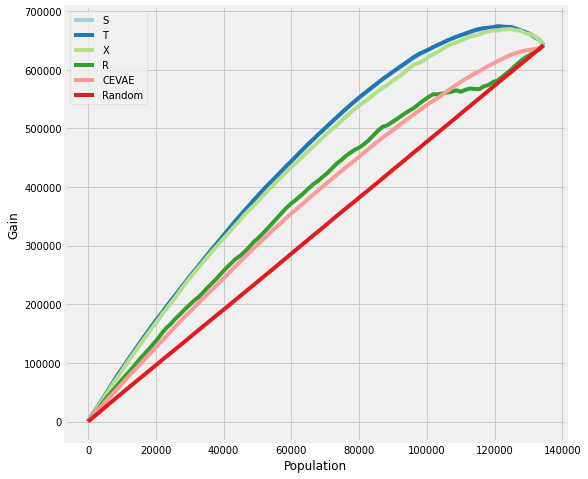

In [25]:
plot_gain(df_preds_val)

# With Synthetic Data Generation

In [ ]:
y, X, w, tau, b, e = simulate_hidden_confounder(n=100000, p=5, sigma=1.0, adj=0.)

X_train, X_val, y_train, y_val, w_train, w_val, tau_train, tau_val, b_train, b_val, e_train, e_val = \
    train_test_split(X, y, w, tau, b, e, test_size=0.2, random_state=123, shuffle=True)

preds_dict_train = {}
preds_dict_valid = {}

preds_dict_train['Actuals'] = tau_train
preds_dict_valid['Actuals'] = tau_val

preds_dict_train['generated_data'] = {
    'y': y_train,
    'X': X_train,
    'w': w_train,
    'tau': tau_train,
    'b': b_train,
    'e': e_train}
preds_dict_valid['generated_data'] = {
    'y': y_val,
    'X': X_val,
    'w': w_val,
    'tau': tau_val,
    'b': b_val,
    'e': e_val}

# Predict p_hat because e would not be directly observed in real-life
p_model = ElasticNetPropensityModel()
p_hat_train = p_model.fit_predict(X_train, w_train)
p_hat_val = p_model.fit_predict(X_val, w_val)

for base_learner, label_l in zip([BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor],
                                 ['S', 'T', 'X', 'R']):
    for model, label_m in zip([LinearRegression, XGBRegressor], ['LR', 'XGB']):
        # RLearner will need to fit on the p_hat
        if label_l != 'R':
            learner = base_learner(model())
            # fit the model on training data only
            learner.fit(X=X_train, treatment=w_train, y=y_train)
            try:
                preds_dict_train['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_train, p=p_hat_train).flatten()
                preds_dict_valid['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_val, p=p_hat_val).flatten()
            except TypeError:
                preds_dict_train['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_train, treatment=w_train, y=y_train).flatten()
                preds_dict_valid['{} Learner ({})'.format(
                    label_l, label_m)] = learner.predict(X=X_val, treatment=w_val, y=y_val).flatten()
        else:
            learner = base_learner(model())
            learner.fit(X=X_train, p=p_hat_train, treatment=w_train, y=y_train)
            preds_dict_train['{} Learner ({})'.format(
                label_l, label_m)] = learner.predict(X=X_train).flatten()
            preds_dict_valid['{} Learner ({})'.format(
                label_l, label_m)] = learner.predict(X=X_val).flatten()

# cevae model settings
outcome_dist = "normal"
latent_dim = 20
hidden_dim = 200
num_epochs = 5
batch_size = 1000
learning_rate = 1e-3
learning_rate_decay = 0.1
num_layers = 3
num_samples = 10

cevae = CEVAE_MODEL(outcome_dist=outcome_dist,
                    latent_dim=latent_dim,
                    hidden_dim=hidden_dim,
                    num_epochs=num_epochs,
                    batch_size=batch_size,
                    learning_rate=learning_rate,
                    learning_rate_decay=learning_rate_decay,
                    num_layers=num_layers,
                    num_samples=num_samples)

# fit
losses = cevae.fit(X=torch.tensor(X_train, dtype=torch.float),
                   treatment=torch.tensor(w_train, dtype=torch.float),
                   y=torch.tensor(y_train, dtype=torch.float))

preds_dict_train['CEVAE'] = cevae.predict(X_train).flatten()
preds_dict_valid['CEVAE'] = cevae.predict(X_val).flatten()

In [27]:
actuals_train = preds_dict_train['Actuals']
actuals_validation = preds_dict_valid['Actuals']

synthetic_summary_train = pd.DataFrame({label: [preds.mean(), mse(preds, actuals_train)] for label, preds
                                        in preds_dict_train.items() if 'generated' not in label.lower()},
                                       index=['ATE', 'MSE']).T
synthetic_summary_train['Abs % Error of ATE'] = np.abs(
    (synthetic_summary_train['ATE']/synthetic_summary_train.loc['Actuals', 'ATE']) - 1)

synthetic_summary_validation = pd.DataFrame({label: [preds.mean(), mse(preds, actuals_validation)]
                                             for label, preds in preds_dict_valid.items()
                                             if 'generated' not in label.lower()},
                                            index=['ATE', 'MSE']).T
synthetic_summary_validation['Abs % Error of ATE'] = np.abs(
    (synthetic_summary_validation['ATE']/synthetic_summary_validation.loc['Actuals', 'ATE']) - 1)

# calculate kl divergence for training
for label in synthetic_summary_train.index:
    stacked_values = np.hstack((preds_dict_train[label], actuals_train))
    stacked_low = np.percentile(stacked_values, 0.1)
    stacked_high = np.percentile(stacked_values, 99.9)
    bins = np.linspace(stacked_low, stacked_high, 100)

    distr = np.histogram(preds_dict_train[label], bins=bins)[0]
    distr = np.clip(distr/distr.sum(), 0.001, 0.999)
    true_distr = np.histogram(actuals_train, bins=bins)[0]
    true_distr = np.clip(true_distr/true_distr.sum(), 0.001, 0.999)

    kl = entropy(distr, true_distr)
    synthetic_summary_train.loc[label, 'KL Divergence'] = kl

# calculate kl divergence for validation
for label in synthetic_summary_validation.index:
    stacked_values = np.hstack((preds_dict_valid[label], actuals_validation))
    stacked_low = np.percentile(stacked_values, 0.1)
    stacked_high = np.percentile(stacked_values, 99.9)
    bins = np.linspace(stacked_low, stacked_high, 100)

    distr = np.histogram(preds_dict_valid[label], bins=bins)[0]
    distr = np.clip(distr/distr.sum(), 0.001, 0.999)
    true_distr = np.histogram(actuals_validation, bins=bins)[0]
    true_distr = np.clip(true_distr/true_distr.sum(), 0.001, 0.999)

    kl = entropy(distr, true_distr)
    synthetic_summary_validation.loc[label, 'KL Divergence'] = kl

In [28]:
df_preds_train = pd.DataFrame([preds_dict_train['S Learner (LR)'].ravel(),
                               preds_dict_train['S Learner (XGB)'].ravel(),
                               preds_dict_train['T Learner (LR)'].ravel(),
                               preds_dict_train['T Learner (XGB)'].ravel(),
                               preds_dict_train['X Learner (LR)'].ravel(),
                               preds_dict_train['X Learner (XGB)'].ravel(),
                               preds_dict_train['R Learner (LR)'].ravel(),
                               preds_dict_train['R Learner (XGB)'].ravel(),                               
                               preds_dict_train['CEVAE'].ravel(),
                               preds_dict_train['generated_data']['tau'].ravel(),
                               preds_dict_train['generated_data']['w'].ravel(),
                               preds_dict_train['generated_data']['y'].ravel()],
                              index=['S Learner (LR)','S Learner (XGB)',
                                     'T Learner (LR)','T Learner (XGB)',
                                     'X Learner (LR)','X Learner (XGB)',
                                     'R Learner (LR)','R Learner (XGB)',
                                     'CEVAE','tau','w','y']).T

synthetic_summary_train['AUUC'] = auuc_score(df_preds_train).iloc[:-1]

In [29]:
df_preds_validation = pd.DataFrame([preds_dict_valid['S Learner (LR)'].ravel(),
                               preds_dict_valid['S Learner (XGB)'].ravel(),
                               preds_dict_valid['T Learner (LR)'].ravel(),
                               preds_dict_valid['T Learner (XGB)'].ravel(),
                               preds_dict_valid['X Learner (LR)'].ravel(),
                               preds_dict_valid['X Learner (XGB)'].ravel(),
                               preds_dict_valid['R Learner (LR)'].ravel(),
                               preds_dict_valid['R Learner (XGB)'].ravel(),                               
                               preds_dict_valid['CEVAE'].ravel(),
                               preds_dict_valid['generated_data']['tau'].ravel(),
                               preds_dict_valid['generated_data']['w'].ravel(),
                               preds_dict_valid['generated_data']['y'].ravel()],
                              index=['S Learner (LR)','S Learner (XGB)',
                                     'T Learner (LR)','T Learner (XGB)',
                                     'X Learner (LR)','X Learner (XGB)',
                                     'R Learner (LR)','R Learner (XGB)',
                                     'CEVAE','tau','w','y']).T

synthetic_summary_validation['AUUC'] = auuc_score(df_preds_validation).iloc[:-1]

In [30]:
synthetic_summary_train

,ATE,MSE,Abs % Error of ATE,KL Divergence,AUUC
Actuals,0.725792,0.000000,0.000000,0.000000,NaN
S Learner (LR),0.833006,0.062674,0.147720,6.278413,0.500368
S Learner (XGB),0.812432,0.043296,0.119372,2.885569,0.555630
T Learner (LR),0.834038,0.059916,0.149141,3.317519,0.523122
T Learner (XGB),0.808236,0.039991,0.113592,2.645884,0.556122
X Learner (LR),0.834038,0.059916,0.149141,3.317519,0.523122
X Learner (XGB),0.807459,0.040138,0.112520,2.691054,0.555965
R Learner (LR),0.834466,0.060503,0.149731,3.529481,0.523089
R Learner (XGB),0.743469,0.039730,0.024355,2.664695,0.545240
CEVAE,0.830692,0.059542,0.144531,3.221986,0.520807


In [31]:
synthetic_summary_validation

,ATE,MSE,Abs % Error of ATE,KL Divergence,AUUC
Actuals,0.727399,0.000000,0.000000,0.000000,NaN
S Learner (LR),0.833006,0.062331,0.145186,6.278413,0.500125
S Learner (XGB),0.813106,0.043173,0.117827,2.888129,0.555109
T Learner (LR),0.834435,0.059677,0.147150,3.323551,0.523005
T Learner (XGB),0.808721,0.040047,0.111798,2.649085,0.555269
X Learner (LR),0.834435,0.059677,0.147150,3.323551,0.523005
X Learner (XGB),0.808028,0.040202,0.110847,2.690740,0.555215
R Learner (LR),0.834767,0.060228,0.147606,3.527051,0.523015
R Learner (XGB),0.743840,0.039875,0.022602,2.667011,0.544475
CEVAE,0.830303,0.059065,0.141469,3.214080,0.521274


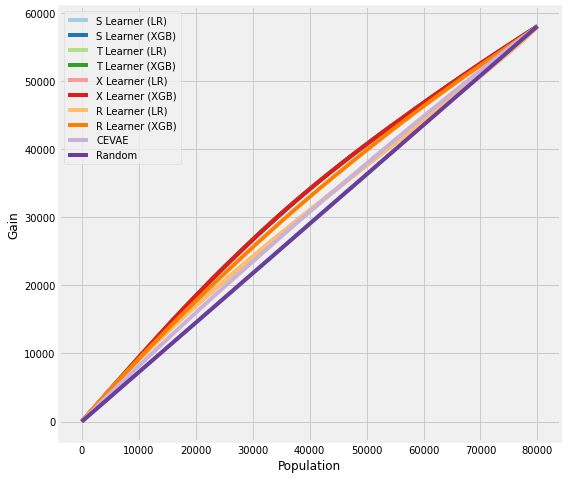

In [32]:
plot_gain(df_preds_train)

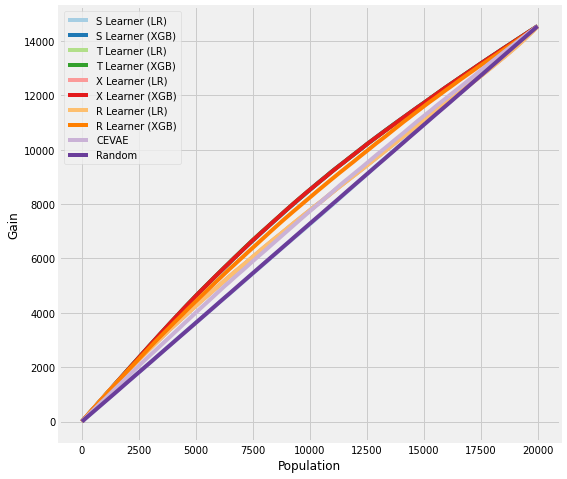

In [33]:
plot_gain(df_preds_validation)